<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Kalman Filtering for Indoor Localization
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pykalman import KalmanFilter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
# Load data
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

In [3]:
# Define the Kalman Filter function for a given array of RSSI measurements.
def kalman_filter_rssi(rssi_measurements):
    kf = KalmanFilter(
        initial_state_mean=rssi_measurements[0],
        observation_covariance=0.5,
        transition_covariance=0.01
    )
    # kf.smooth returns a tuple: (smoothed_state_means, smoothed_state_covariances)
    return kf.smooth(rssi_measurements)[0].flatten()

# Apply the Kalman filter per device group.
df['filtered_rssi'] = df.groupby('device_id')['rssi'].transform(
    lambda x: kalman_filter_rssi(x.values)
)

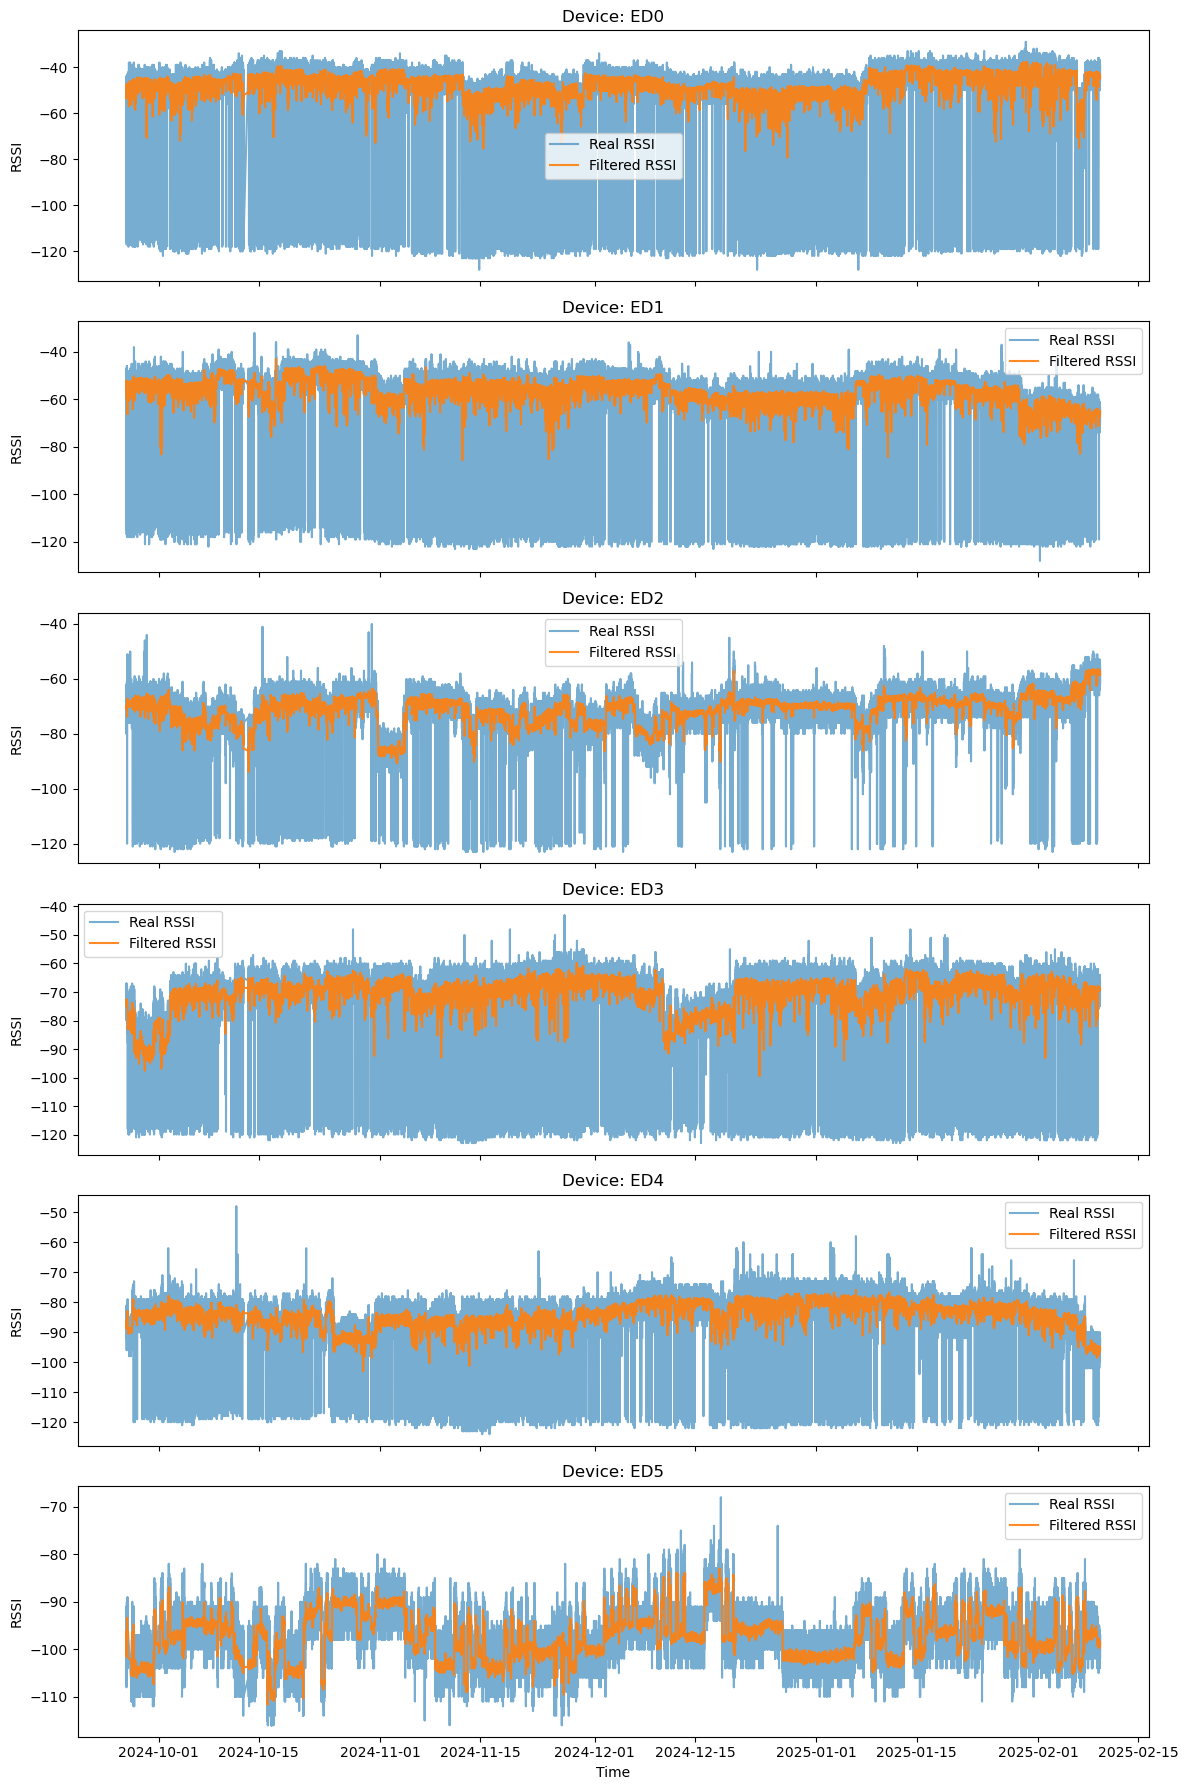

In [4]:
# Get unique device ids for plotting
device_ids = df['device_id'].unique()

# Create a subplot for each device (in one column)
num_devices = len(device_ids)
fig, axes = plt.subplots(nrows=num_devices, ncols=1, figsize=(12, 3*num_devices), sharex=True)

# In case there's only one device, ensure axes is iterable
if num_devices == 1:
    axes = [axes]

# Plot real vs. filtered RSSI for each device.
for ax, device in zip(axes, device_ids):
    # Select data corresponding to the current device
    device_data = df[df['device_id'] == device].sort_values('time')
    
    # Plot the original and filtered RSSI
    ax.plot(device_data['time'], device_data['rssi'], label='Real RSSI', alpha=0.6)
    ax.plot(device_data['time'], device_data['filtered_rssi'], label='Filtered RSSI', alpha=0.9)
    
    ax.set_title(f'Device: {device}')
    ax.set_ylabel('RSSI')
    ax.legend()
    
# Set the common x-label for the entire figure
plt.xlabel('Time')
plt.tight_layout()
plt.show()